# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

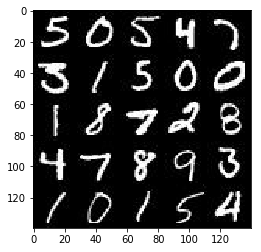

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

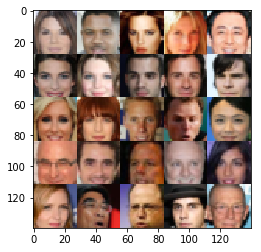

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name = 'real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name = 'fake')
    lr = tf.placeholder(tf.float32,name = 'learning_rate')

    return (input_real, input_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse = reuse):
        alpha = 0.02
        
        x1 = tf.layers.conv2d(images,64,5,strides = 2,padding = 'same')
        relu1 = tf.maximum(alpha * x1,x1)
        
        x2 = tf.layers.conv2d(relu1,128,5,strides = 2,padding = 'same')
        bn2 = tf.layers.batch_normalization(x2,training = True)
        relu2 = tf.maximum(alpha * bn2,bn2)
        
        x3 = tf.layers.conv2d(relu2,256,5,strides = 2,padding = 'same')
        bn3 = tf.layers.batch_normalization(x3,training = True)
        relu3 = tf.maximum(alpha * bn3,bn3)
        
        flat = tf.reshape(relu3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return (out,logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.02
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out
    
    
    
      


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.6802... Generator Loss: 2.2999
Epoch 1/2... Batch 20... Discriminator Loss: 0.0114... Generator Loss: 4.9986
Epoch 1/2... Batch 30... Discriminator Loss: 0.0254... Generator Loss: 9.3130
Epoch 1/2... Batch 40... Discriminator Loss: 0.1558... Generator Loss: 2.8973
Epoch 1/2... Batch 50... Discriminator Loss: 2.5188... Generator Loss: 0.2901
Epoch 1/2... Batch 60... Discriminator Loss: 0.1722... Generator Loss: 3.4890
Epoch 1/2... Batch 70... Discriminator Loss: 0.3010... Generator Loss: 3.3238
Epoch 1/2... Batch 80... Discriminator Loss: 6.3707... Generator Loss: 16.5148
Epoch 1/2... Batch 90... Discriminator Loss: 0.5967... Generator Loss: 1.7324
Epoch 1/2... Batch 100... Discriminator Loss: 0.0612... Generator Loss: 3.7296


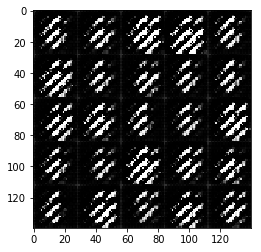

Epoch 1/2... Batch 110... Discriminator Loss: 0.1206... Generator Loss: 2.9200
Epoch 1/2... Batch 120... Discriminator Loss: 1.6673... Generator Loss: 0.4488
Epoch 1/2... Batch 130... Discriminator Loss: 0.1164... Generator Loss: 3.1253
Epoch 1/2... Batch 140... Discriminator Loss: 0.0745... Generator Loss: 3.0013
Epoch 1/2... Batch 150... Discriminator Loss: 1.6584... Generator Loss: 1.1017
Epoch 1/2... Batch 160... Discriminator Loss: 0.4248... Generator Loss: 4.4681
Epoch 1/2... Batch 170... Discriminator Loss: 0.2428... Generator Loss: 2.3496
Epoch 1/2... Batch 180... Discriminator Loss: 0.2531... Generator Loss: 4.7415
Epoch 1/2... Batch 190... Discriminator Loss: 0.7830... Generator Loss: 1.6925
Epoch 1/2... Batch 200... Discriminator Loss: 0.3532... Generator Loss: 3.6322


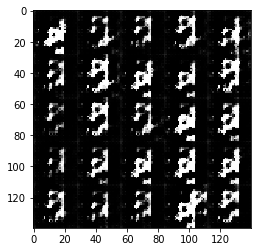

Epoch 1/2... Batch 210... Discriminator Loss: 0.3183... Generator Loss: 2.5431
Epoch 1/2... Batch 220... Discriminator Loss: 0.1690... Generator Loss: 3.4374
Epoch 1/2... Batch 230... Discriminator Loss: 0.1582... Generator Loss: 2.6756
Epoch 1/2... Batch 240... Discriminator Loss: 0.2892... Generator Loss: 4.7620
Epoch 1/2... Batch 250... Discriminator Loss: 0.2737... Generator Loss: 4.3304
Epoch 1/2... Batch 260... Discriminator Loss: 0.9912... Generator Loss: 0.8345
Epoch 1/2... Batch 270... Discriminator Loss: 0.7179... Generator Loss: 1.6012
Epoch 1/2... Batch 280... Discriminator Loss: 0.2923... Generator Loss: 5.5100
Epoch 1/2... Batch 290... Discriminator Loss: 1.1329... Generator Loss: 1.1755
Epoch 1/2... Batch 300... Discriminator Loss: 0.3202... Generator Loss: 3.2940


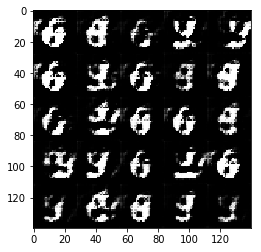

Epoch 1/2... Batch 310... Discriminator Loss: 0.2554... Generator Loss: 3.8150
Epoch 1/2... Batch 320... Discriminator Loss: 1.0789... Generator Loss: 7.4202
Epoch 1/2... Batch 330... Discriminator Loss: 0.5126... Generator Loss: 1.3158
Epoch 1/2... Batch 340... Discriminator Loss: 0.1954... Generator Loss: 5.4706
Epoch 1/2... Batch 350... Discriminator Loss: 0.2367... Generator Loss: 3.0139
Epoch 1/2... Batch 360... Discriminator Loss: 0.5323... Generator Loss: 1.4367
Epoch 1/2... Batch 370... Discriminator Loss: 0.7472... Generator Loss: 1.0889
Epoch 1/2... Batch 380... Discriminator Loss: 0.2289... Generator Loss: 4.0089
Epoch 1/2... Batch 390... Discriminator Loss: 1.0273... Generator Loss: 0.9408
Epoch 1/2... Batch 400... Discriminator Loss: 0.3032... Generator Loss: 2.3525


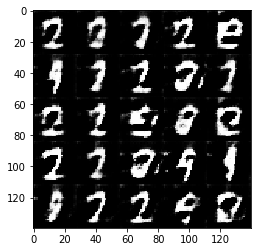

Epoch 1/2... Batch 410... Discriminator Loss: 0.4345... Generator Loss: 6.0771
Epoch 1/2... Batch 420... Discriminator Loss: 1.3300... Generator Loss: 0.7083
Epoch 1/2... Batch 430... Discriminator Loss: 0.5244... Generator Loss: 1.9802
Epoch 1/2... Batch 440... Discriminator Loss: 1.2812... Generator Loss: 0.7336
Epoch 1/2... Batch 450... Discriminator Loss: 0.4335... Generator Loss: 2.8948
Epoch 1/2... Batch 460... Discriminator Loss: 0.2537... Generator Loss: 2.7330
Epoch 1/2... Batch 470... Discriminator Loss: 2.0609... Generator Loss: 5.7870
Epoch 1/2... Batch 480... Discriminator Loss: 0.7729... Generator Loss: 1.1676
Epoch 1/2... Batch 490... Discriminator Loss: 0.7148... Generator Loss: 1.0131
Epoch 1/2... Batch 500... Discriminator Loss: 1.2561... Generator Loss: 0.5026


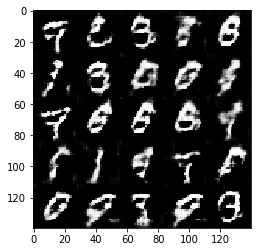

Epoch 1/2... Batch 510... Discriminator Loss: 0.5815... Generator Loss: 2.1151
Epoch 1/2... Batch 520... Discriminator Loss: 0.5571... Generator Loss: 1.3361
Epoch 1/2... Batch 530... Discriminator Loss: 0.6968... Generator Loss: 1.3099
Epoch 1/2... Batch 540... Discriminator Loss: 0.3750... Generator Loss: 2.4261
Epoch 1/2... Batch 550... Discriminator Loss: 0.7381... Generator Loss: 1.1721
Epoch 1/2... Batch 560... Discriminator Loss: 0.7167... Generator Loss: 3.4368
Epoch 1/2... Batch 570... Discriminator Loss: 0.6017... Generator Loss: 1.3939
Epoch 1/2... Batch 580... Discriminator Loss: 0.6554... Generator Loss: 1.4276
Epoch 1/2... Batch 590... Discriminator Loss: 1.3601... Generator Loss: 0.4565
Epoch 1/2... Batch 600... Discriminator Loss: 0.7375... Generator Loss: 1.1611


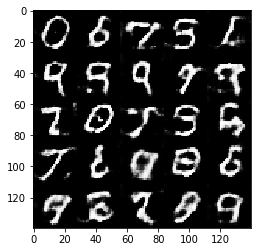

Epoch 1/2... Batch 610... Discriminator Loss: 0.4228... Generator Loss: 2.3920
Epoch 1/2... Batch 620... Discriminator Loss: 0.4567... Generator Loss: 1.7291
Epoch 1/2... Batch 630... Discriminator Loss: 1.0589... Generator Loss: 0.9300
Epoch 1/2... Batch 640... Discriminator Loss: 0.4948... Generator Loss: 1.7060
Epoch 1/2... Batch 650... Discriminator Loss: 0.8613... Generator Loss: 2.4857
Epoch 1/2... Batch 660... Discriminator Loss: 0.8733... Generator Loss: 1.1198
Epoch 1/2... Batch 670... Discriminator Loss: 0.6668... Generator Loss: 1.2686
Epoch 1/2... Batch 680... Discriminator Loss: 0.9216... Generator Loss: 0.8799
Epoch 1/2... Batch 690... Discriminator Loss: 0.9172... Generator Loss: 3.2826
Epoch 1/2... Batch 700... Discriminator Loss: 0.8757... Generator Loss: 2.8485


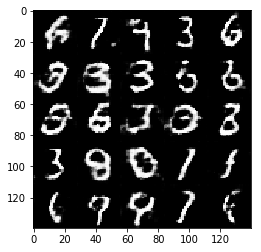

Epoch 1/2... Batch 710... Discriminator Loss: 0.6839... Generator Loss: 1.2228
Epoch 1/2... Batch 720... Discriminator Loss: 0.8445... Generator Loss: 0.9151
Epoch 1/2... Batch 730... Discriminator Loss: 0.8292... Generator Loss: 0.9349
Epoch 1/2... Batch 740... Discriminator Loss: 0.9677... Generator Loss: 0.8786
Epoch 1/2... Batch 750... Discriminator Loss: 0.7989... Generator Loss: 1.0023
Epoch 1/2... Batch 760... Discriminator Loss: 0.6911... Generator Loss: 1.0708
Epoch 1/2... Batch 770... Discriminator Loss: 2.2124... Generator Loss: 5.6464
Epoch 1/2... Batch 780... Discriminator Loss: 0.9612... Generator Loss: 0.7594
Epoch 1/2... Batch 790... Discriminator Loss: 0.9507... Generator Loss: 0.9359
Epoch 1/2... Batch 800... Discriminator Loss: 0.9980... Generator Loss: 0.9812


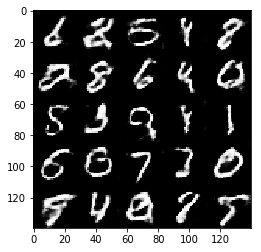

Epoch 1/2... Batch 810... Discriminator Loss: 1.0322... Generator Loss: 2.0262
Epoch 1/2... Batch 820... Discriminator Loss: 0.7545... Generator Loss: 1.1200
Epoch 1/2... Batch 830... Discriminator Loss: 1.0711... Generator Loss: 0.7893
Epoch 1/2... Batch 840... Discriminator Loss: 1.6679... Generator Loss: 0.3310
Epoch 1/2... Batch 850... Discriminator Loss: 1.2296... Generator Loss: 0.5662
Epoch 1/2... Batch 860... Discriminator Loss: 1.2157... Generator Loss: 0.5734
Epoch 1/2... Batch 870... Discriminator Loss: 0.9850... Generator Loss: 0.9989
Epoch 1/2... Batch 880... Discriminator Loss: 2.0656... Generator Loss: 0.1932
Epoch 1/2... Batch 890... Discriminator Loss: 0.9976... Generator Loss: 1.7420
Epoch 1/2... Batch 900... Discriminator Loss: 0.7424... Generator Loss: 1.5060


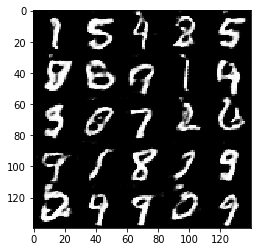

Epoch 1/2... Batch 910... Discriminator Loss: 1.7386... Generator Loss: 0.3166
Epoch 1/2... Batch 920... Discriminator Loss: 1.1964... Generator Loss: 0.5745
Epoch 1/2... Batch 930... Discriminator Loss: 0.8900... Generator Loss: 1.2729
Epoch 2/2... Batch 10... Discriminator Loss: 0.7873... Generator Loss: 1.5881
Epoch 2/2... Batch 20... Discriminator Loss: 1.8547... Generator Loss: 0.2666
Epoch 2/2... Batch 30... Discriminator Loss: 1.0191... Generator Loss: 0.7133
Epoch 2/2... Batch 40... Discriminator Loss: 0.9346... Generator Loss: 1.3419
Epoch 2/2... Batch 50... Discriminator Loss: 0.8334... Generator Loss: 1.4996
Epoch 2/2... Batch 60... Discriminator Loss: 1.0016... Generator Loss: 2.1905
Epoch 2/2... Batch 70... Discriminator Loss: 1.5759... Generator Loss: 0.2972
Epoch 2/2... Batch 80... Discriminator Loss: 1.2855... Generator Loss: 2.5429
Epoch 2/2... Batch 90... Discriminator Loss: 0.8619... Generator Loss: 0.8563
Epoch 2/2... Batch 100... Discriminator Loss: 1.9254... Gener

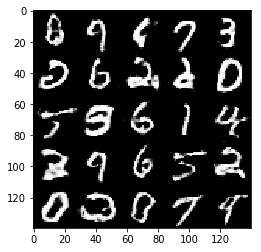

Epoch 2/2... Batch 110... Discriminator Loss: 0.9270... Generator Loss: 0.9868
Epoch 2/2... Batch 120... Discriminator Loss: 1.1328... Generator Loss: 1.5147
Epoch 2/2... Batch 130... Discriminator Loss: 0.9684... Generator Loss: 1.2245
Epoch 2/2... Batch 140... Discriminator Loss: 0.9909... Generator Loss: 0.7651
Epoch 2/2... Batch 150... Discriminator Loss: 1.2156... Generator Loss: 1.7591
Epoch 2/2... Batch 160... Discriminator Loss: 1.2854... Generator Loss: 0.5101
Epoch 2/2... Batch 170... Discriminator Loss: 1.4803... Generator Loss: 2.3926
Epoch 2/2... Batch 180... Discriminator Loss: 1.0960... Generator Loss: 1.3774
Epoch 2/2... Batch 190... Discriminator Loss: 1.1364... Generator Loss: 0.5616
Epoch 2/2... Batch 200... Discriminator Loss: 1.4687... Generator Loss: 2.8878


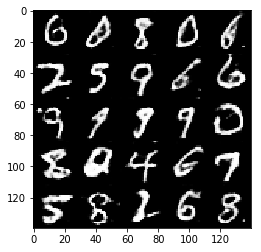

Epoch 2/2... Batch 210... Discriminator Loss: 1.1213... Generator Loss: 0.6056
Epoch 2/2... Batch 220... Discriminator Loss: 0.7220... Generator Loss: 1.2965
Epoch 2/2... Batch 230... Discriminator Loss: 1.0705... Generator Loss: 0.6348
Epoch 2/2... Batch 240... Discriminator Loss: 1.5755... Generator Loss: 0.3283
Epoch 2/2... Batch 250... Discriminator Loss: 0.7295... Generator Loss: 1.4177
Epoch 2/2... Batch 260... Discriminator Loss: 1.0771... Generator Loss: 2.0040
Epoch 2/2... Batch 270... Discriminator Loss: 1.5143... Generator Loss: 0.3356
Epoch 2/2... Batch 280... Discriminator Loss: 0.9973... Generator Loss: 2.0353
Epoch 2/2... Batch 290... Discriminator Loss: 0.9733... Generator Loss: 0.8949
Epoch 2/2... Batch 300... Discriminator Loss: 1.0428... Generator Loss: 1.3343


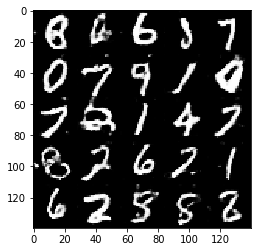

Epoch 2/2... Batch 310... Discriminator Loss: 0.9826... Generator Loss: 1.7000
Epoch 2/2... Batch 320... Discriminator Loss: 1.1583... Generator Loss: 3.2300
Epoch 2/2... Batch 330... Discriminator Loss: 1.6837... Generator Loss: 0.3294
Epoch 2/2... Batch 340... Discriminator Loss: 1.6021... Generator Loss: 0.3377
Epoch 2/2... Batch 350... Discriminator Loss: 0.9279... Generator Loss: 1.9752
Epoch 2/2... Batch 360... Discriminator Loss: 1.0274... Generator Loss: 0.8972
Epoch 2/2... Batch 370... Discriminator Loss: 1.0550... Generator Loss: 1.7371
Epoch 2/2... Batch 380... Discriminator Loss: 1.3236... Generator Loss: 2.2689
Epoch 2/2... Batch 390... Discriminator Loss: 0.9569... Generator Loss: 0.8502
Epoch 2/2... Batch 400... Discriminator Loss: 1.0861... Generator Loss: 0.6668


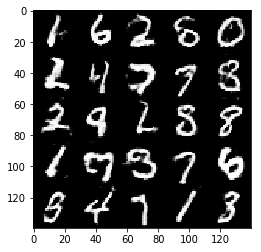

Epoch 2/2... Batch 410... Discriminator Loss: 0.8155... Generator Loss: 1.1465
Epoch 2/2... Batch 420... Discriminator Loss: 1.5144... Generator Loss: 0.4669
Epoch 2/2... Batch 430... Discriminator Loss: 1.4409... Generator Loss: 0.3659
Epoch 2/2... Batch 440... Discriminator Loss: 1.0400... Generator Loss: 0.7441
Epoch 2/2... Batch 450... Discriminator Loss: 1.2345... Generator Loss: 0.5313
Epoch 2/2... Batch 460... Discriminator Loss: 0.9111... Generator Loss: 1.4878
Epoch 2/2... Batch 470... Discriminator Loss: 1.0525... Generator Loss: 0.7564
Epoch 2/2... Batch 480... Discriminator Loss: 1.0428... Generator Loss: 1.1702
Epoch 2/2... Batch 490... Discriminator Loss: 0.8243... Generator Loss: 1.9568
Epoch 2/2... Batch 500... Discriminator Loss: 0.7874... Generator Loss: 2.1628


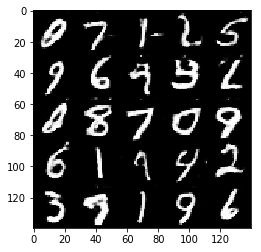

Epoch 2/2... Batch 510... Discriminator Loss: 0.9517... Generator Loss: 1.1146
Epoch 2/2... Batch 520... Discriminator Loss: 0.9186... Generator Loss: 0.8239
Epoch 2/2... Batch 530... Discriminator Loss: 1.3189... Generator Loss: 0.4545
Epoch 2/2... Batch 540... Discriminator Loss: 1.1492... Generator Loss: 0.5874
Epoch 2/2... Batch 550... Discriminator Loss: 0.9314... Generator Loss: 1.5515
Epoch 2/2... Batch 560... Discriminator Loss: 0.7387... Generator Loss: 1.4569
Epoch 2/2... Batch 570... Discriminator Loss: 0.9662... Generator Loss: 2.7253
Epoch 2/2... Batch 580... Discriminator Loss: 0.9324... Generator Loss: 0.8396
Epoch 2/2... Batch 590... Discriminator Loss: 1.8343... Generator Loss: 0.3049
Epoch 2/2... Batch 600... Discriminator Loss: 0.9523... Generator Loss: 1.2878


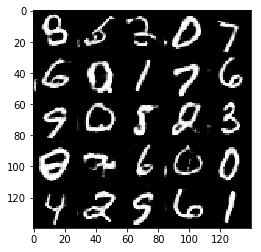

Epoch 2/2... Batch 610... Discriminator Loss: 0.9056... Generator Loss: 0.9120
Epoch 2/2... Batch 620... Discriminator Loss: 0.8445... Generator Loss: 1.4051
Epoch 2/2... Batch 630... Discriminator Loss: 1.0203... Generator Loss: 0.8600
Epoch 2/2... Batch 640... Discriminator Loss: 0.9103... Generator Loss: 1.2346
Epoch 2/2... Batch 650... Discriminator Loss: 0.9773... Generator Loss: 1.3483
Epoch 2/2... Batch 660... Discriminator Loss: 0.9199... Generator Loss: 0.8295
Epoch 2/2... Batch 670... Discriminator Loss: 1.3132... Generator Loss: 0.5257
Epoch 2/2... Batch 680... Discriminator Loss: 0.8800... Generator Loss: 0.7437
Epoch 2/2... Batch 690... Discriminator Loss: 1.1283... Generator Loss: 0.6621
Epoch 2/2... Batch 700... Discriminator Loss: 2.0011... Generator Loss: 0.1998


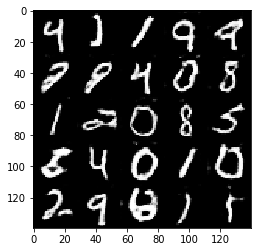

Epoch 2/2... Batch 710... Discriminator Loss: 0.7478... Generator Loss: 1.1313
Epoch 2/2... Batch 720... Discriminator Loss: 2.1259... Generator Loss: 0.2190
Epoch 2/2... Batch 730... Discriminator Loss: 0.8788... Generator Loss: 1.9601
Epoch 2/2... Batch 740... Discriminator Loss: 1.7672... Generator Loss: 0.3275
Epoch 2/2... Batch 750... Discriminator Loss: 0.9053... Generator Loss: 0.8072
Epoch 2/2... Batch 760... Discriminator Loss: 1.1347... Generator Loss: 1.1626
Epoch 2/2... Batch 770... Discriminator Loss: 0.9819... Generator Loss: 0.8381
Epoch 2/2... Batch 780... Discriminator Loss: 0.8816... Generator Loss: 1.0745
Epoch 2/2... Batch 790... Discriminator Loss: 0.9147... Generator Loss: 1.3736
Epoch 2/2... Batch 800... Discriminator Loss: 1.0250... Generator Loss: 0.9773


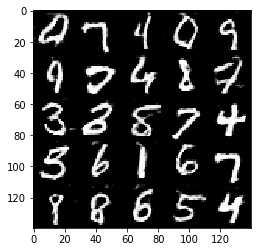

Epoch 2/2... Batch 810... Discriminator Loss: 0.9287... Generator Loss: 1.0322
Epoch 2/2... Batch 820... Discriminator Loss: 1.2498... Generator Loss: 0.4928
Epoch 2/2... Batch 830... Discriminator Loss: 1.1186... Generator Loss: 0.6644
Epoch 2/2... Batch 840... Discriminator Loss: 1.0982... Generator Loss: 0.6787
Epoch 2/2... Batch 850... Discriminator Loss: 2.0377... Generator Loss: 0.2601
Epoch 2/2... Batch 860... Discriminator Loss: 0.8031... Generator Loss: 1.2230
Epoch 2/2... Batch 870... Discriminator Loss: 0.9518... Generator Loss: 0.8640
Epoch 2/2... Batch 880... Discriminator Loss: 1.2009... Generator Loss: 0.5222
Epoch 2/2... Batch 890... Discriminator Loss: 1.1967... Generator Loss: 0.5312
Epoch 2/2... Batch 900... Discriminator Loss: 0.7851... Generator Loss: 1.7176


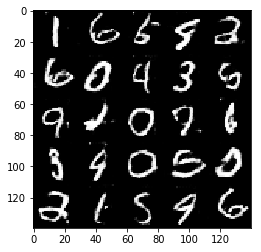

Epoch 2/2... Batch 910... Discriminator Loss: 2.3680... Generator Loss: 0.1650
Epoch 2/2... Batch 920... Discriminator Loss: 1.4510... Generator Loss: 0.4022
Epoch 2/2... Batch 930... Discriminator Loss: 0.9693... Generator Loss: 0.7821


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.1071... Generator Loss: 0.7070
Epoch 1/1... Batch 20... Discriminator Loss: 0.7539... Generator Loss: 1.2070
Epoch 1/1... Batch 30... Discriminator Loss: 0.6418... Generator Loss: 1.5031
Epoch 1/1... Batch 40... Discriminator Loss: 0.4657... Generator Loss: 1.8124
Epoch 1/1... Batch 50... Discriminator Loss: 0.3365... Generator Loss: 2.2283
Epoch 1/1... Batch 60... Discriminator Loss: 0.2549... Generator Loss: 2.2391
Epoch 1/1... Batch 70... Discriminator Loss: 0.3370... Generator Loss: 1.8646
Epoch 1/1... Batch 80... Discriminator Loss: 0.2965... Generator Loss: 2.1431
Epoch 1/1... Batch 90... Discriminator Loss: 0.2596... Generator Loss: 1.8579
Epoch 1/1... Batch 100... Discriminator Loss: 0.2470... Generator Loss: 2.3357


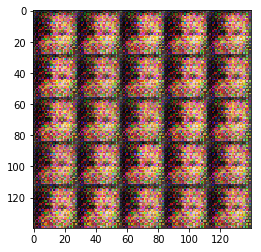

Epoch 1/1... Batch 110... Discriminator Loss: 0.3201... Generator Loss: 2.3754
Epoch 1/1... Batch 120... Discriminator Loss: 0.2630... Generator Loss: 2.2348
Epoch 1/1... Batch 130... Discriminator Loss: 0.1212... Generator Loss: 3.1287
Epoch 1/1... Batch 140... Discriminator Loss: 0.3655... Generator Loss: 2.0940
Epoch 1/1... Batch 150... Discriminator Loss: 0.2102... Generator Loss: 2.4130
Epoch 1/1... Batch 160... Discriminator Loss: 0.0969... Generator Loss: 2.9819
Epoch 1/1... Batch 170... Discriminator Loss: 0.2960... Generator Loss: 2.0380
Epoch 1/1... Batch 180... Discriminator Loss: 0.2688... Generator Loss: 2.3815
Epoch 1/1... Batch 190... Discriminator Loss: 0.1141... Generator Loss: 3.6391
Epoch 1/1... Batch 200... Discriminator Loss: 0.1780... Generator Loss: 3.9567


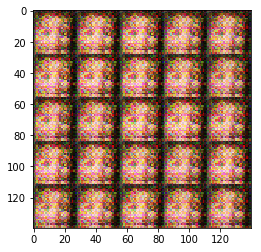

Epoch 1/1... Batch 210... Discriminator Loss: 0.2117... Generator Loss: 3.3154
Epoch 1/1... Batch 220... Discriminator Loss: 0.0908... Generator Loss: 3.6077
Epoch 1/1... Batch 230... Discriminator Loss: 0.2617... Generator Loss: 2.2888
Epoch 1/1... Batch 240... Discriminator Loss: 0.2204... Generator Loss: 2.1444
Epoch 1/1... Batch 250... Discriminator Loss: 0.0901... Generator Loss: 3.3383
Epoch 1/1... Batch 260... Discriminator Loss: 0.0698... Generator Loss: 3.5349
Epoch 1/1... Batch 270... Discriminator Loss: 0.0965... Generator Loss: 3.1530
Epoch 1/1... Batch 280... Discriminator Loss: 0.0699... Generator Loss: 3.5559
Epoch 1/1... Batch 290... Discriminator Loss: 0.0783... Generator Loss: 3.2487
Epoch 1/1... Batch 300... Discriminator Loss: 0.1455... Generator Loss: 2.8506


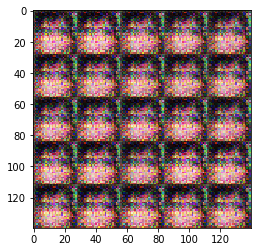

Epoch 1/1... Batch 310... Discriminator Loss: 0.0978... Generator Loss: 2.7744
Epoch 1/1... Batch 320... Discriminator Loss: 0.1399... Generator Loss: 2.8999
Epoch 1/1... Batch 330... Discriminator Loss: 0.0632... Generator Loss: 3.5116
Epoch 1/1... Batch 340... Discriminator Loss: 0.1351... Generator Loss: 2.7212
Epoch 1/1... Batch 350... Discriminator Loss: 0.0986... Generator Loss: 3.0993
Epoch 1/1... Batch 360... Discriminator Loss: 0.0999... Generator Loss: 3.2084
Epoch 1/1... Batch 370... Discriminator Loss: 0.0876... Generator Loss: 3.4538
Epoch 1/1... Batch 380... Discriminator Loss: 0.0804... Generator Loss: 3.3981
Epoch 1/1... Batch 390... Discriminator Loss: 0.0515... Generator Loss: 3.9239
Epoch 1/1... Batch 400... Discriminator Loss: 0.1452... Generator Loss: 2.7337


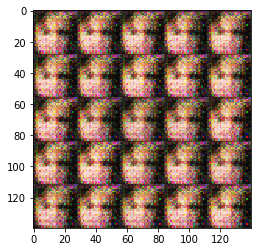

Epoch 1/1... Batch 410... Discriminator Loss: 0.1720... Generator Loss: 2.1335
Epoch 1/1... Batch 420... Discriminator Loss: 0.0982... Generator Loss: 3.4305
Epoch 1/1... Batch 430... Discriminator Loss: 0.2096... Generator Loss: 5.4873
Epoch 1/1... Batch 440... Discriminator Loss: 1.4929... Generator Loss: 0.3307
Epoch 1/1... Batch 450... Discriminator Loss: 1.1808... Generator Loss: 4.7238
Epoch 1/1... Batch 460... Discriminator Loss: 0.3774... Generator Loss: 2.1390
Epoch 1/1... Batch 470... Discriminator Loss: 0.1765... Generator Loss: 2.2520
Epoch 1/1... Batch 480... Discriminator Loss: 0.4284... Generator Loss: 1.4941
Epoch 1/1... Batch 490... Discriminator Loss: 0.3562... Generator Loss: 2.1989
Epoch 1/1... Batch 500... Discriminator Loss: 0.1940... Generator Loss: 3.2812


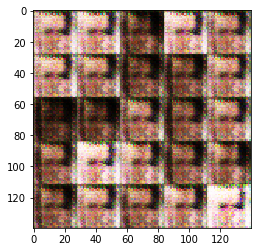

Epoch 1/1... Batch 510... Discriminator Loss: 0.6182... Generator Loss: 3.7135
Epoch 1/1... Batch 520... Discriminator Loss: 0.2483... Generator Loss: 2.2408
Epoch 1/1... Batch 530... Discriminator Loss: 0.4465... Generator Loss: 1.3521
Epoch 1/1... Batch 540... Discriminator Loss: 0.2759... Generator Loss: 2.0984
Epoch 1/1... Batch 550... Discriminator Loss: 0.3685... Generator Loss: 4.1094
Epoch 1/1... Batch 560... Discriminator Loss: 0.3947... Generator Loss: 1.8096
Epoch 1/1... Batch 570... Discriminator Loss: 0.1976... Generator Loss: 3.9925
Epoch 1/1... Batch 580... Discriminator Loss: 0.2829... Generator Loss: 2.2931
Epoch 1/1... Batch 590... Discriminator Loss: 0.4431... Generator Loss: 1.4757
Epoch 1/1... Batch 600... Discriminator Loss: 0.2630... Generator Loss: 3.1005


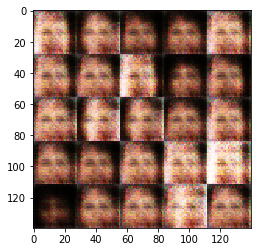

Epoch 1/1... Batch 610... Discriminator Loss: 0.3363... Generator Loss: 1.6120
Epoch 1/1... Batch 620... Discriminator Loss: 0.2179... Generator Loss: 2.2975
Epoch 1/1... Batch 630... Discriminator Loss: 0.2041... Generator Loss: 2.6349
Epoch 1/1... Batch 640... Discriminator Loss: 0.2647... Generator Loss: 3.8585
Epoch 1/1... Batch 650... Discriminator Loss: 0.1316... Generator Loss: 2.7891
Epoch 1/1... Batch 660... Discriminator Loss: 0.1909... Generator Loss: 2.7585
Epoch 1/1... Batch 670... Discriminator Loss: 0.1919... Generator Loss: 2.3797
Epoch 1/1... Batch 680... Discriminator Loss: 0.1785... Generator Loss: 2.3918
Epoch 1/1... Batch 690... Discriminator Loss: 0.5413... Generator Loss: 1.2166
Epoch 1/1... Batch 700... Discriminator Loss: 0.4457... Generator Loss: 3.8202


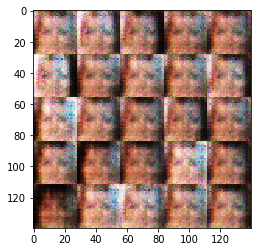

Epoch 1/1... Batch 710... Discriminator Loss: 0.2403... Generator Loss: 2.1020
Epoch 1/1... Batch 720... Discriminator Loss: 0.5412... Generator Loss: 4.2105
Epoch 1/1... Batch 730... Discriminator Loss: 0.3178... Generator Loss: 4.1097
Epoch 1/1... Batch 740... Discriminator Loss: 0.1238... Generator Loss: 4.0071
Epoch 1/1... Batch 750... Discriminator Loss: 0.1963... Generator Loss: 2.8003
Epoch 1/1... Batch 760... Discriminator Loss: 0.2748... Generator Loss: 3.7581
Epoch 1/1... Batch 770... Discriminator Loss: 0.2596... Generator Loss: 3.0884
Epoch 1/1... Batch 780... Discriminator Loss: 0.3034... Generator Loss: 1.9573
Epoch 1/1... Batch 790... Discriminator Loss: 0.2808... Generator Loss: 1.8887
Epoch 1/1... Batch 800... Discriminator Loss: 0.1945... Generator Loss: 2.7365


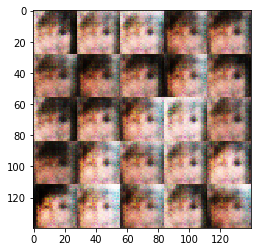

Epoch 1/1... Batch 810... Discriminator Loss: 0.4221... Generator Loss: 4.9049
Epoch 1/1... Batch 820... Discriminator Loss: 0.3481... Generator Loss: 3.7997
Epoch 1/1... Batch 830... Discriminator Loss: 0.1721... Generator Loss: 3.0755
Epoch 1/1... Batch 840... Discriminator Loss: 0.8299... Generator Loss: 0.7786
Epoch 1/1... Batch 850... Discriminator Loss: 0.6081... Generator Loss: 5.0987
Epoch 1/1... Batch 860... Discriminator Loss: 0.3755... Generator Loss: 3.0648
Epoch 1/1... Batch 870... Discriminator Loss: 0.3516... Generator Loss: 2.4013
Epoch 1/1... Batch 880... Discriminator Loss: 0.2869... Generator Loss: 2.1154
Epoch 1/1... Batch 890... Discriminator Loss: 0.3301... Generator Loss: 2.6957
Epoch 1/1... Batch 900... Discriminator Loss: 0.3193... Generator Loss: 1.9321


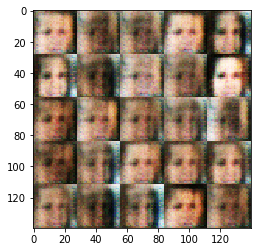

Epoch 1/1... Batch 910... Discriminator Loss: 0.3741... Generator Loss: 3.0108
Epoch 1/1... Batch 920... Discriminator Loss: 0.3282... Generator Loss: 2.6801
Epoch 1/1... Batch 930... Discriminator Loss: 0.5121... Generator Loss: 1.9701
Epoch 1/1... Batch 940... Discriminator Loss: 0.3365... Generator Loss: 3.2267
Epoch 1/1... Batch 950... Discriminator Loss: 0.4000... Generator Loss: 1.7623
Epoch 1/1... Batch 960... Discriminator Loss: 0.1783... Generator Loss: 3.4161
Epoch 1/1... Batch 970... Discriminator Loss: 0.4101... Generator Loss: 1.6610
Epoch 1/1... Batch 980... Discriminator Loss: 0.3047... Generator Loss: 2.0600
Epoch 1/1... Batch 990... Discriminator Loss: 0.3171... Generator Loss: 2.6617
Epoch 1/1... Batch 1000... Discriminator Loss: 0.5381... Generator Loss: 1.6260


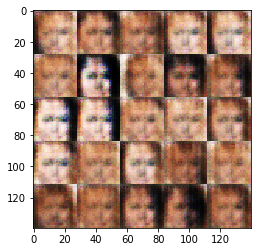

Epoch 1/1... Batch 1010... Discriminator Loss: 0.3694... Generator Loss: 2.6008
Epoch 1/1... Batch 1020... Discriminator Loss: 0.4668... Generator Loss: 1.6500
Epoch 1/1... Batch 1030... Discriminator Loss: 0.2980... Generator Loss: 2.3085
Epoch 1/1... Batch 1040... Discriminator Loss: 0.5084... Generator Loss: 4.2910
Epoch 1/1... Batch 1050... Discriminator Loss: 0.2666... Generator Loss: 2.3614
Epoch 1/1... Batch 1060... Discriminator Loss: 0.2735... Generator Loss: 2.1870
Epoch 1/1... Batch 1070... Discriminator Loss: 0.3799... Generator Loss: 1.8570
Epoch 1/1... Batch 1080... Discriminator Loss: 0.5096... Generator Loss: 1.6053
Epoch 1/1... Batch 1090... Discriminator Loss: 0.3133... Generator Loss: 1.8685
Epoch 1/1... Batch 1100... Discriminator Loss: 0.3387... Generator Loss: 1.7963


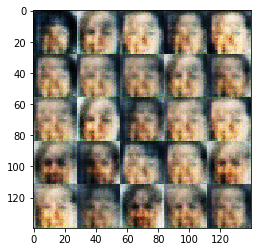

Epoch 1/1... Batch 1110... Discriminator Loss: 0.2631... Generator Loss: 2.1770
Epoch 1/1... Batch 1120... Discriminator Loss: 0.1832... Generator Loss: 3.1885
Epoch 1/1... Batch 1130... Discriminator Loss: 0.3058... Generator Loss: 2.2682
Epoch 1/1... Batch 1140... Discriminator Loss: 0.3306... Generator Loss: 3.2996
Epoch 1/1... Batch 1150... Discriminator Loss: 0.2557... Generator Loss: 3.2440
Epoch 1/1... Batch 1160... Discriminator Loss: 0.5631... Generator Loss: 2.5215
Epoch 1/1... Batch 1170... Discriminator Loss: 1.1530... Generator Loss: 0.7009
Epoch 1/1... Batch 1180... Discriminator Loss: 1.0730... Generator Loss: 3.8082
Epoch 1/1... Batch 1190... Discriminator Loss: 0.3715... Generator Loss: 1.8794
Epoch 1/1... Batch 1200... Discriminator Loss: 0.5656... Generator Loss: 1.3967


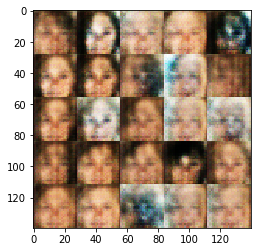

Epoch 1/1... Batch 1210... Discriminator Loss: 0.2989... Generator Loss: 2.4822
Epoch 1/1... Batch 1220... Discriminator Loss: 0.3902... Generator Loss: 2.9125
Epoch 1/1... Batch 1230... Discriminator Loss: 0.3193... Generator Loss: 2.2979
Epoch 1/1... Batch 1240... Discriminator Loss: 0.3085... Generator Loss: 2.7048
Epoch 1/1... Batch 1250... Discriminator Loss: 0.9885... Generator Loss: 1.0247
Epoch 1/1... Batch 1260... Discriminator Loss: 0.3179... Generator Loss: 2.3110
Epoch 1/1... Batch 1270... Discriminator Loss: 0.6313... Generator Loss: 1.1900
Epoch 1/1... Batch 1280... Discriminator Loss: 0.3000... Generator Loss: 2.2923
Epoch 1/1... Batch 1290... Discriminator Loss: 0.3483... Generator Loss: 2.3963
Epoch 1/1... Batch 1300... Discriminator Loss: 0.7628... Generator Loss: 0.9560


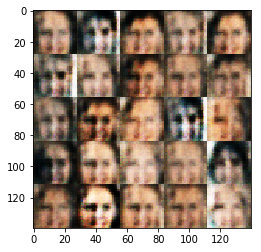

Epoch 1/1... Batch 1310... Discriminator Loss: 0.3575... Generator Loss: 2.2056
Epoch 1/1... Batch 1320... Discriminator Loss: 1.0589... Generator Loss: 0.7168
Epoch 1/1... Batch 1330... Discriminator Loss: 0.4334... Generator Loss: 1.7561
Epoch 1/1... Batch 1340... Discriminator Loss: 0.5156... Generator Loss: 1.9819
Epoch 1/1... Batch 1350... Discriminator Loss: 0.6805... Generator Loss: 1.3285
Epoch 1/1... Batch 1360... Discriminator Loss: 0.4445... Generator Loss: 1.8294
Epoch 1/1... Batch 1370... Discriminator Loss: 0.6013... Generator Loss: 1.1448
Epoch 1/1... Batch 1380... Discriminator Loss: 0.6358... Generator Loss: 2.8852
Epoch 1/1... Batch 1390... Discriminator Loss: 0.8697... Generator Loss: 0.8697
Epoch 1/1... Batch 1400... Discriminator Loss: 0.5115... Generator Loss: 2.4353


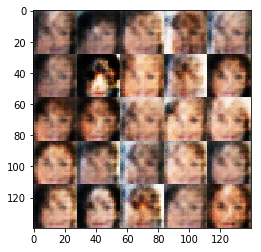

Epoch 1/1... Batch 1410... Discriminator Loss: 0.5589... Generator Loss: 2.1124
Epoch 1/1... Batch 1420... Discriminator Loss: 0.4738... Generator Loss: 1.7940
Epoch 1/1... Batch 1430... Discriminator Loss: 1.0281... Generator Loss: 0.6108
Epoch 1/1... Batch 1440... Discriminator Loss: 0.5415... Generator Loss: 1.5317
Epoch 1/1... Batch 1450... Discriminator Loss: 0.4989... Generator Loss: 1.8058
Epoch 1/1... Batch 1460... Discriminator Loss: 0.5369... Generator Loss: 1.5263
Epoch 1/1... Batch 1470... Discriminator Loss: 0.3963... Generator Loss: 1.7785
Epoch 1/1... Batch 1480... Discriminator Loss: 0.4522... Generator Loss: 2.2274
Epoch 1/1... Batch 1490... Discriminator Loss: 0.5169... Generator Loss: 1.6497
Epoch 1/1... Batch 1500... Discriminator Loss: 0.5445... Generator Loss: 1.7369


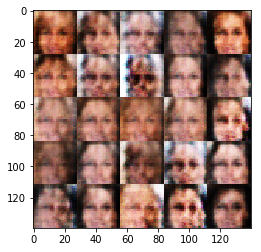

Epoch 1/1... Batch 1510... Discriminator Loss: 0.4829... Generator Loss: 1.7101
Epoch 1/1... Batch 1520... Discriminator Loss: 0.5616... Generator Loss: 1.8655
Epoch 1/1... Batch 1530... Discriminator Loss: 0.5672... Generator Loss: 1.4328
Epoch 1/1... Batch 1540... Discriminator Loss: 0.6285... Generator Loss: 2.7354
Epoch 1/1... Batch 1550... Discriminator Loss: 0.9259... Generator Loss: 0.8613
Epoch 1/1... Batch 1560... Discriminator Loss: 0.6600... Generator Loss: 2.6804
Epoch 1/1... Batch 1570... Discriminator Loss: 0.5551... Generator Loss: 1.6567
Epoch 1/1... Batch 1580... Discriminator Loss: 0.5165... Generator Loss: 1.7704
Epoch 1/1... Batch 1590... Discriminator Loss: 0.5384... Generator Loss: 1.7287
Epoch 1/1... Batch 1600... Discriminator Loss: 0.3959... Generator Loss: 2.0712


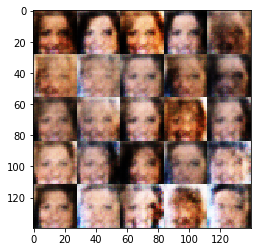

Epoch 1/1... Batch 1610... Discriminator Loss: 1.3362... Generator Loss: 0.5332
Epoch 1/1... Batch 1620... Discriminator Loss: 0.5760... Generator Loss: 1.5176
Epoch 1/1... Batch 1630... Discriminator Loss: 0.4203... Generator Loss: 2.2650
Epoch 1/1... Batch 1640... Discriminator Loss: 0.6183... Generator Loss: 1.5551
Epoch 1/1... Batch 1650... Discriminator Loss: 0.4126... Generator Loss: 2.5622
Epoch 1/1... Batch 1660... Discriminator Loss: 0.6294... Generator Loss: 1.2240
Epoch 1/1... Batch 1670... Discriminator Loss: 0.5700... Generator Loss: 1.4838
Epoch 1/1... Batch 1680... Discriminator Loss: 0.4392... Generator Loss: 1.7012
Epoch 1/1... Batch 1690... Discriminator Loss: 0.3667... Generator Loss: 2.0513
Epoch 1/1... Batch 1700... Discriminator Loss: 0.8293... Generator Loss: 0.9005


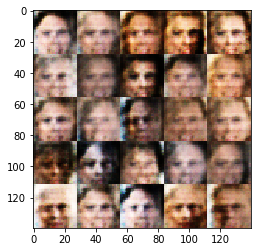

Epoch 1/1... Batch 1710... Discriminator Loss: 0.5900... Generator Loss: 1.6243
Epoch 1/1... Batch 1720... Discriminator Loss: 0.6946... Generator Loss: 1.2768
Epoch 1/1... Batch 1730... Discriminator Loss: 0.4858... Generator Loss: 3.1195
Epoch 1/1... Batch 1740... Discriminator Loss: 0.3928... Generator Loss: 2.5990
Epoch 1/1... Batch 1750... Discriminator Loss: 0.6858... Generator Loss: 2.0272
Epoch 1/1... Batch 1760... Discriminator Loss: 0.5379... Generator Loss: 1.5375
Epoch 1/1... Batch 1770... Discriminator Loss: 1.4120... Generator Loss: 0.4994
Epoch 1/1... Batch 1780... Discriminator Loss: 0.6263... Generator Loss: 1.9581
Epoch 1/1... Batch 1790... Discriminator Loss: 0.8011... Generator Loss: 2.1112
Epoch 1/1... Batch 1800... Discriminator Loss: 0.5905... Generator Loss: 2.4433


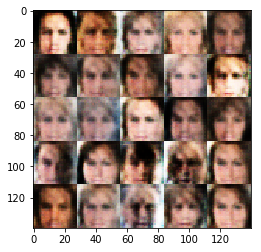

Epoch 1/1... Batch 1810... Discriminator Loss: 0.6272... Generator Loss: 1.2916
Epoch 1/1... Batch 1820... Discriminator Loss: 0.6850... Generator Loss: 1.2077
Epoch 1/1... Batch 1830... Discriminator Loss: 0.5654... Generator Loss: 1.9392
Epoch 1/1... Batch 1840... Discriminator Loss: 0.4385... Generator Loss: 1.8343
Epoch 1/1... Batch 1850... Discriminator Loss: 0.5304... Generator Loss: 1.5486
Epoch 1/1... Batch 1860... Discriminator Loss: 0.4702... Generator Loss: 1.9714
Epoch 1/1... Batch 1870... Discriminator Loss: 0.4386... Generator Loss: 1.6214
Epoch 1/1... Batch 1880... Discriminator Loss: 0.3801... Generator Loss: 2.2904
Epoch 1/1... Batch 1890... Discriminator Loss: 0.3840... Generator Loss: 1.8780
Epoch 1/1... Batch 1900... Discriminator Loss: 0.4770... Generator Loss: 1.6868


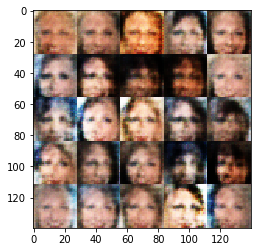

Epoch 1/1... Batch 1910... Discriminator Loss: 0.5050... Generator Loss: 1.6649
Epoch 1/1... Batch 1920... Discriminator Loss: 1.0664... Generator Loss: 3.8246
Epoch 1/1... Batch 1930... Discriminator Loss: 0.3800... Generator Loss: 2.0251
Epoch 1/1... Batch 1940... Discriminator Loss: 0.6324... Generator Loss: 1.3970
Epoch 1/1... Batch 1950... Discriminator Loss: 0.3930... Generator Loss: 2.2707
Epoch 1/1... Batch 1960... Discriminator Loss: 0.6582... Generator Loss: 2.3703
Epoch 1/1... Batch 1970... Discriminator Loss: 0.6188... Generator Loss: 2.8578
Epoch 1/1... Batch 1980... Discriminator Loss: 0.6973... Generator Loss: 1.4502
Epoch 1/1... Batch 1990... Discriminator Loss: 0.5444... Generator Loss: 1.9095
Epoch 1/1... Batch 2000... Discriminator Loss: 0.5379... Generator Loss: 2.7947


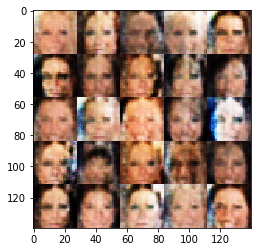

Epoch 1/1... Batch 2010... Discriminator Loss: 0.5406... Generator Loss: 2.2469
Epoch 1/1... Batch 2020... Discriminator Loss: 0.9166... Generator Loss: 0.7337
Epoch 1/1... Batch 2030... Discriminator Loss: 0.2891... Generator Loss: 2.7501
Epoch 1/1... Batch 2040... Discriminator Loss: 0.6227... Generator Loss: 1.4094
Epoch 1/1... Batch 2050... Discriminator Loss: 0.7565... Generator Loss: 1.5166
Epoch 1/1... Batch 2060... Discriminator Loss: 0.5637... Generator Loss: 1.5135
Epoch 1/1... Batch 2070... Discriminator Loss: 0.4704... Generator Loss: 1.8046
Epoch 1/1... Batch 2080... Discriminator Loss: 0.6173... Generator Loss: 1.2080
Epoch 1/1... Batch 2090... Discriminator Loss: 0.5303... Generator Loss: 1.4665
Epoch 1/1... Batch 2100... Discriminator Loss: 0.4871... Generator Loss: 1.7378


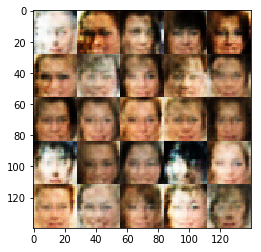

Epoch 1/1... Batch 2110... Discriminator Loss: 0.5332... Generator Loss: 2.7685
Epoch 1/1... Batch 2120... Discriminator Loss: 0.5564... Generator Loss: 1.6500
Epoch 1/1... Batch 2130... Discriminator Loss: 0.4597... Generator Loss: 1.7912
Epoch 1/1... Batch 2140... Discriminator Loss: 0.4756... Generator Loss: 1.5146
Epoch 1/1... Batch 2150... Discriminator Loss: 0.5067... Generator Loss: 1.5202
Epoch 1/1... Batch 2160... Discriminator Loss: 1.4255... Generator Loss: 4.7566
Epoch 1/1... Batch 2170... Discriminator Loss: 0.8094... Generator Loss: 0.9329
Epoch 1/1... Batch 2180... Discriminator Loss: 0.6681... Generator Loss: 1.4600
Epoch 1/1... Batch 2190... Discriminator Loss: 0.5732... Generator Loss: 1.8978
Epoch 1/1... Batch 2200... Discriminator Loss: 0.5229... Generator Loss: 1.9353


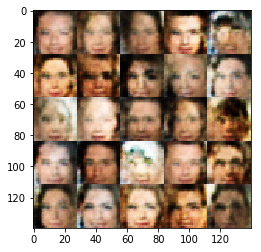

Epoch 1/1... Batch 2210... Discriminator Loss: 0.5620... Generator Loss: 1.3811
Epoch 1/1... Batch 2220... Discriminator Loss: 0.6652... Generator Loss: 1.1131
Epoch 1/1... Batch 2230... Discriminator Loss: 0.5298... Generator Loss: 1.4209
Epoch 1/1... Batch 2240... Discriminator Loss: 0.3921... Generator Loss: 2.6932
Epoch 1/1... Batch 2250... Discriminator Loss: 0.4990... Generator Loss: 1.6231
Epoch 1/1... Batch 2260... Discriminator Loss: 0.6030... Generator Loss: 3.5091
Epoch 1/1... Batch 2270... Discriminator Loss: 0.4258... Generator Loss: 2.2889
Epoch 1/1... Batch 2280... Discriminator Loss: 0.5423... Generator Loss: 1.7105
Epoch 1/1... Batch 2290... Discriminator Loss: 0.5160... Generator Loss: 1.5132
Epoch 1/1... Batch 2300... Discriminator Loss: 1.1636... Generator Loss: 3.4882


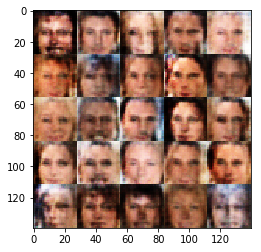

Epoch 1/1... Batch 2310... Discriminator Loss: 0.6253... Generator Loss: 1.6367
Epoch 1/1... Batch 2320... Discriminator Loss: 0.5998... Generator Loss: 1.3533
Epoch 1/1... Batch 2330... Discriminator Loss: 0.6096... Generator Loss: 1.3092
Epoch 1/1... Batch 2340... Discriminator Loss: 0.4973... Generator Loss: 3.1204
Epoch 1/1... Batch 2350... Discriminator Loss: 0.6497... Generator Loss: 1.5230
Epoch 1/1... Batch 2360... Discriminator Loss: 0.4174... Generator Loss: 2.0608
Epoch 1/1... Batch 2370... Discriminator Loss: 0.6793... Generator Loss: 1.4813
Epoch 1/1... Batch 2380... Discriminator Loss: 0.5470... Generator Loss: 1.7890
Epoch 1/1... Batch 2390... Discriminator Loss: 0.7304... Generator Loss: 1.2865
Epoch 1/1... Batch 2400... Discriminator Loss: 0.4119... Generator Loss: 2.2510


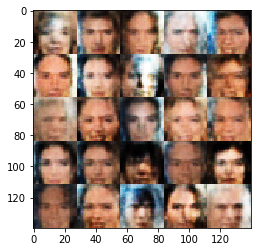

Epoch 1/1... Batch 2410... Discriminator Loss: 0.5268... Generator Loss: 1.5589
Epoch 1/1... Batch 2420... Discriminator Loss: 0.4849... Generator Loss: 2.7110
Epoch 1/1... Batch 2430... Discriminator Loss: 0.6606... Generator Loss: 2.0758
Epoch 1/1... Batch 2440... Discriminator Loss: 0.4749... Generator Loss: 1.5640
Epoch 1/1... Batch 2450... Discriminator Loss: 0.6661... Generator Loss: 1.2597
Epoch 1/1... Batch 2460... Discriminator Loss: 0.9618... Generator Loss: 0.7634
Epoch 1/1... Batch 2470... Discriminator Loss: 0.5327... Generator Loss: 1.9244
Epoch 1/1... Batch 2480... Discriminator Loss: 0.5081... Generator Loss: 1.6716
Epoch 1/1... Batch 2490... Discriminator Loss: 0.4038... Generator Loss: 1.9862
Epoch 1/1... Batch 2500... Discriminator Loss: 0.5090... Generator Loss: 1.5294


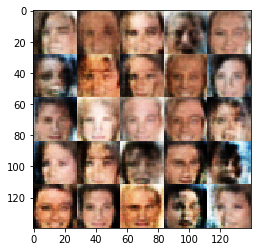

Epoch 1/1... Batch 2510... Discriminator Loss: 0.5147... Generator Loss: 2.2857
Epoch 1/1... Batch 2520... Discriminator Loss: 0.6108... Generator Loss: 1.3440
Epoch 1/1... Batch 2530... Discriminator Loss: 0.7207... Generator Loss: 3.6200
Epoch 1/1... Batch 2540... Discriminator Loss: 0.6017... Generator Loss: 1.3256
Epoch 1/1... Batch 2550... Discriminator Loss: 0.3612... Generator Loss: 1.8659
Epoch 1/1... Batch 2560... Discriminator Loss: 0.6655... Generator Loss: 1.1908
Epoch 1/1... Batch 2570... Discriminator Loss: 1.5909... Generator Loss: 0.3672
Epoch 1/1... Batch 2580... Discriminator Loss: 0.6206... Generator Loss: 1.3765
Epoch 1/1... Batch 2590... Discriminator Loss: 0.7325... Generator Loss: 1.0549
Epoch 1/1... Batch 2600... Discriminator Loss: 0.4708... Generator Loss: 2.6447


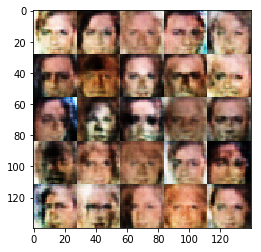

Epoch 1/1... Batch 2610... Discriminator Loss: 0.7128... Generator Loss: 1.1082
Epoch 1/1... Batch 2620... Discriminator Loss: 0.5303... Generator Loss: 1.6601
Epoch 1/1... Batch 2630... Discriminator Loss: 1.3438... Generator Loss: 4.0001
Epoch 1/1... Batch 2640... Discriminator Loss: 0.5602... Generator Loss: 1.6678
Epoch 1/1... Batch 2650... Discriminator Loss: 0.4844... Generator Loss: 1.8494
Epoch 1/1... Batch 2660... Discriminator Loss: 0.8210... Generator Loss: 0.8976
Epoch 1/1... Batch 2670... Discriminator Loss: 1.0454... Generator Loss: 0.7303
Epoch 1/1... Batch 2680... Discriminator Loss: 0.7253... Generator Loss: 1.3293
Epoch 1/1... Batch 2690... Discriminator Loss: 0.7569... Generator Loss: 0.8591
Epoch 1/1... Batch 2700... Discriminator Loss: 0.4969... Generator Loss: 1.6898


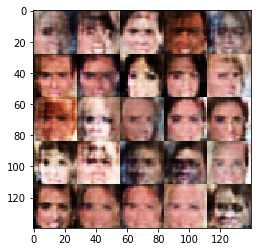

Epoch 1/1... Batch 2710... Discriminator Loss: 0.6068... Generator Loss: 3.1831
Epoch 1/1... Batch 2720... Discriminator Loss: 0.6242... Generator Loss: 1.2746
Epoch 1/1... Batch 2730... Discriminator Loss: 0.3715... Generator Loss: 1.8872
Epoch 1/1... Batch 2740... Discriminator Loss: 0.6115... Generator Loss: 2.7542
Epoch 1/1... Batch 2750... Discriminator Loss: 0.9126... Generator Loss: 1.1210
Epoch 1/1... Batch 2760... Discriminator Loss: 0.4342... Generator Loss: 2.4999
Epoch 1/1... Batch 2770... Discriminator Loss: 0.6655... Generator Loss: 1.2683
Epoch 1/1... Batch 2780... Discriminator Loss: 0.2350... Generator Loss: 2.9109
Epoch 1/1... Batch 2790... Discriminator Loss: 0.6580... Generator Loss: 1.4354
Epoch 1/1... Batch 2800... Discriminator Loss: 0.8633... Generator Loss: 1.8455


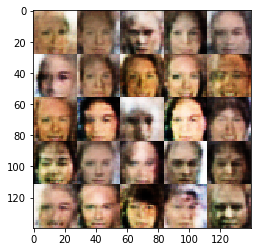

Epoch 1/1... Batch 2810... Discriminator Loss: 0.7536... Generator Loss: 1.1821
Epoch 1/1... Batch 2820... Discriminator Loss: 0.6063... Generator Loss: 1.7769
Epoch 1/1... Batch 2830... Discriminator Loss: 0.6411... Generator Loss: 1.2434
Epoch 1/1... Batch 2840... Discriminator Loss: 0.4970... Generator Loss: 3.2683
Epoch 1/1... Batch 2850... Discriminator Loss: 0.7994... Generator Loss: 2.5439
Epoch 1/1... Batch 2860... Discriminator Loss: 0.3756... Generator Loss: 1.7220
Epoch 1/1... Batch 2870... Discriminator Loss: 0.7938... Generator Loss: 0.9031
Epoch 1/1... Batch 2880... Discriminator Loss: 0.4479... Generator Loss: 1.9101
Epoch 1/1... Batch 2890... Discriminator Loss: 0.6958... Generator Loss: 2.1935
Epoch 1/1... Batch 2900... Discriminator Loss: 0.5832... Generator Loss: 1.2406


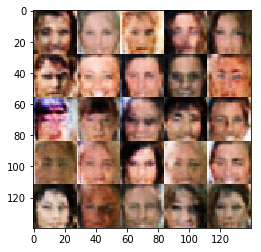

Epoch 1/1... Batch 2910... Discriminator Loss: 0.6159... Generator Loss: 1.7713
Epoch 1/1... Batch 2920... Discriminator Loss: 0.7441... Generator Loss: 1.1693
Epoch 1/1... Batch 2930... Discriminator Loss: 0.6048... Generator Loss: 1.7777
Epoch 1/1... Batch 2940... Discriminator Loss: 0.5210... Generator Loss: 2.1416
Epoch 1/1... Batch 2950... Discriminator Loss: 0.4154... Generator Loss: 1.5594
Epoch 1/1... Batch 2960... Discriminator Loss: 1.0105... Generator Loss: 0.6525
Epoch 1/1... Batch 2970... Discriminator Loss: 0.8647... Generator Loss: 0.8767
Epoch 1/1... Batch 2980... Discriminator Loss: 1.0021... Generator Loss: 0.7021
Epoch 1/1... Batch 2990... Discriminator Loss: 0.6650... Generator Loss: 2.0288
Epoch 1/1... Batch 3000... Discriminator Loss: 0.5795... Generator Loss: 1.2449


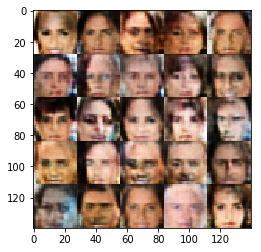

Epoch 1/1... Batch 3010... Discriminator Loss: 0.7142... Generator Loss: 0.9981
Epoch 1/1... Batch 3020... Discriminator Loss: 0.5284... Generator Loss: 2.0853
Epoch 1/1... Batch 3030... Discriminator Loss: 0.5869... Generator Loss: 2.5196
Epoch 1/1... Batch 3040... Discriminator Loss: 0.6154... Generator Loss: 1.3560
Epoch 1/1... Batch 3050... Discriminator Loss: 0.5377... Generator Loss: 1.6761
Epoch 1/1... Batch 3060... Discriminator Loss: 0.4744... Generator Loss: 1.9528
Epoch 1/1... Batch 3070... Discriminator Loss: 0.9322... Generator Loss: 0.7683
Epoch 1/1... Batch 3080... Discriminator Loss: 0.7941... Generator Loss: 1.5086
Epoch 1/1... Batch 3090... Discriminator Loss: 0.4833... Generator Loss: 2.6488
Epoch 1/1... Batch 3100... Discriminator Loss: 0.5119... Generator Loss: 1.4573


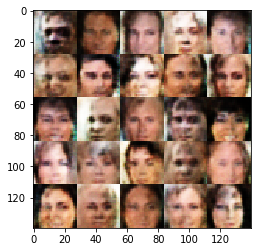

Epoch 1/1... Batch 3110... Discriminator Loss: 0.4901... Generator Loss: 1.6192
Epoch 1/1... Batch 3120... Discriminator Loss: 0.6746... Generator Loss: 1.2431
Epoch 1/1... Batch 3130... Discriminator Loss: 0.7458... Generator Loss: 0.9528
Epoch 1/1... Batch 3140... Discriminator Loss: 0.7677... Generator Loss: 1.3335
Epoch 1/1... Batch 3150... Discriminator Loss: 0.7652... Generator Loss: 1.1493
Epoch 1/1... Batch 3160... Discriminator Loss: 0.6874... Generator Loss: 1.2823


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.